In [1]:
import os
import numpy as np
import torch
import json
import cv2
import matplotlib.pyplot as plt
from thop import profile
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

from network import HDRTransformer
from utils import list_all_files_sorted, read_expo_times, read_images, read_label, ldr_to_hdr
from losses import compute_losses, compute_metrics
from skimage.metrics import peak_signal_noise_ratio

In [2]:
test_path = '/data/asim/ISP/HDR_transformer/data/Test/PAPER/BarbequeDay'
exposure_file_path = os.path.join(test_path, 'exposure.txt')
ldr_file_path = list_all_files_sorted(test_path, '.tif')
expoTimes = read_expo_times(exposure_file_path)

# Read LDR images
ldr_images = read_images(ldr_file_path)

# Read HDR label
label = read_label(test_path, 'HDRImg.hdr')

# Image processing
crop_h, crop_w = 1000, 1000  # Reduce size if needed (e.g., 512x512)

pre_img0 = ldr_to_hdr(ldr_images[0], expoTimes[0], 2.2)
pre_img1 = ldr_to_hdr(ldr_images[1], expoTimes[1], 2.2)
pre_img2 = ldr_to_hdr(ldr_images[2], expoTimes[2], 2.2)

# Concatenate linear domain + LDR domain
pre_img0 = np.concatenate((pre_img0, ldr_images[0]), axis=2)
pre_img1 = np.concatenate((pre_img1, ldr_images[1]), axis=2)
pre_img2 = np.concatenate((pre_img2, ldr_images[2]), axis=2)

# Crop the images
x, y = 0, 0
img0 = pre_img0[x:x + crop_h, y:y + crop_w].astype(np.float32).transpose(2, 0, 1)
img1 = pre_img1[x:x + crop_h, y:y + crop_w].astype(np.float32).transpose(2, 0, 1)
img2 = pre_img2[x:x + crop_h, y:y + crop_w].astype(np.float32).transpose(2, 0, 1)
label = label[x:x + crop_h, y:y + crop_w].astype(np.float32).transpose(2, 0, 1)

# Move tensors to GPU with FP16 precision to reduce memory usage
test_sample = {
    'input0': torch.tensor(img0).cuda().unsqueeze(0),  # FP16 format
    'input1': torch.tensor(img1).cuda().unsqueeze(0),  
    'input2': torch.tensor(img2).cuda().unsqueeze(0),  
    'label': torch.tensor(label).cuda().unsqueeze(0)  # FP16 format
}

# Clear CUDA cache before loading model
torch.cuda.empty_cache()

# Load the HDR Transformer model
net = HDRTransformer(embed_dim=60, depths=[6, 6, 6], num_heads=[6, 6, 6], mlp_ratio=2, in_chans=6)
net = net.cuda()

# Load pre-trained weights (ignore mismatches if necessary)
net.load_state_dict(torch.load('./Results/HDRTransformer.pkl', map_location='cuda'))

# Evaluation mode
net.eval()

with torch.no_grad():
    output = net(test_sample)


/home/asim/.conda/envs/asimenv/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Flops 12590776320.0


In [ ]:
# Compute FLOPs and parameters
flops, params = profile(net, inputs=(test_sample,))

print(f" FLOPs: {flops}")
print(f" Parameters: {params}")

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_relu() for <class 'torch.nn.modules.activation.LeakyReLU'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.normalization.LayerNorm'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_softmax() for <class 'torch.nn.modules.activation.Softmax'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.


🔹 FLOPs: 1199226016200.0
🔹 Parameters: 1197813.0


In [15]:
output['p'].shape, test_sample['label'].shape

(torch.Size([1, 3, 1000, 1000]), torch.Size([1, 3, 1000, 1000]))

In [3]:
with open("params.json", "r") as file:
    params = json.load(file)
metrics = peak_signal_noise_ratio(test_sample['label'].cpu().numpy().astype(np.float32), output['p'].cpu().numpy().astype(np.float32), data_range=1.0)
metrics

32.4268210389315

(1000, 1000, 3)


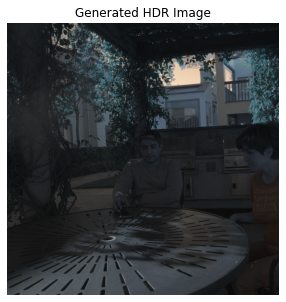

In [17]:
output_img = output['p'].squeeze(0).cpu().numpy()  # Shape: [3, H, W]

# Transpose to HxWxC (OpenCV format)
output_img = np.transpose(output_img, (1, 2, 0))  # Shape: [H, W, 3]

# Normalize to [0,1] if needed (only if values are outside this range)
#output_img = np.clip(output_img, 0, 1)  # Ensure values are valid HDR

# Save as HDR file
cv2.imwrite(".Results/output_hdr.hdr", output_img)
print(output_img.shape)
# Visualize HDR image using Matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(output_img ** (1/2.2))  # Apply gamma correction for better visualization
plt.axis("off")
plt.title("Generated HDR Image")
plt.show()

(1000, 1000, 3)


/tmp/ipykernel_2641281/1007965406.py:15: RuntimeWarning: invalid value encountered in power
  hdr_image_corrected = np.power(hdr_image_normalized, 1/gamma)


Text(0.5, 1.0, 'Loaded HDR Image with Gamma Correction')

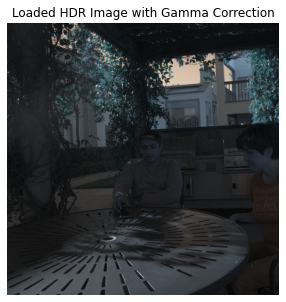

In [18]:
hdr_image = cv2.imread("/data/asim/ISP/HDR_transformer/data/Test/PAPER/BarbequeDay/HDRImg.hdr", -1)  # Replace with your file path



hdr_image = hdr_image[x:x + crop_h, y:y + crop_w].astype(np.float32)
# Check if the image was loaded successfully
if hdr_image is None:
    raise ValueError("Error: HDR image not found or could not be loaded.")

# Normalize for visualization (HDR images have high dynamic range)
hdr_image_normalized = cv2.normalize(hdr_image, None, 0, 1, cv2.NORM_MINMAX)
print(hdr_image_normalized.shape)
# Apply gamma correction (to simulate human perception)
gamma = 2.2
hdr_image_corrected = np.power(hdr_image_normalized, 1/gamma)

# Plot the HDR image
plt.figure(figsize=(10, 5))
plt.imshow(hdr_image_corrected)
plt.axis("off")
plt.title("Loaded HDR Image with Gamma Correction")